<a href="https://colab.research.google.com/github/bhimrazy/voyage-imaging/blob/main/Tuberculosis_(TB)_Detection_from_Chest_X_ray_using_Deep_transfer_Learning_(PyTorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Title: Tuberculosis (TB) Detection from Chest X-ray using Deep Transfer Learning (PyTorch)
Domain: Medical Imaging

## Team Name : Voyage
### Team Members:
- Bhimraj Yadav
- Bibek Nepal
- Kyush Maskey
- Nishan Rai



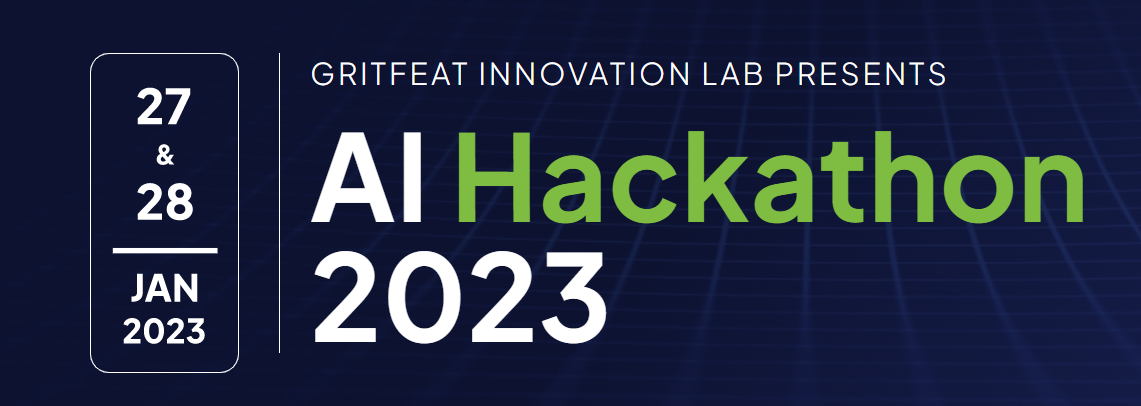

## Introduction:

### Background
Tuberculosis (TB) is a communicable disease which is a major public health problem in Nepal. It is one of 
the top 10 causes of death worldwide and in Nepal, and the leading cause of death from a single infectious 
agent (ranking above HIV/AIDS).

In Nepal, an estimated 69,000 fell ill with TB during FY 2077/78. National Tuberculosis Programme (NTP) 
registered 28,677 (nearly 58% missing vs. the projection) all forms of TB cases (38% female and 62% male). 
Out of 28,677 all forms of TB cases, 28,182 incident TB cases.

> Source : Department of Health Services
2077/78 (2020/21) | Annual Report

### Goal and Objective
The goal of this project is to develop an AI-based solution for detecting tuberculosis from chest X-ray images using transfer learning approach. The solution aims to improve the accuracy and efficiency of TB diagnosis. We aim to use the pre-trained model to detect the signs of TB in chest X-ray images and fine-tune the model to improve the performance. Our solution aims to assist healthcare providers and help in addressing the TB epidemic, particularly in under-served areas where access to healthcare is limited.

### Dataset:
We have used Tuberculosis (TB) Chest X-ray Database to train  and evaluate our model.

#### [Tuberculosis (TB) Chest X-ray Database](https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset)
A team of researchers from Qatar University, Doha, Qatar, and the University of Dhaka, Bangladesh along with their collaborators from Malaysia in collaboration with medical doctors from Hamad Medical Corporation and Bangladesh have created a database of chest X-ray images for Tuberculosis (TB) positive cases along with Normal images. In our current release, there are 700 TB images publicly accessible and 2800 TB images can be downloaded from NIAID TB portal[3] by signing an agreement, and 3500 normal images.

> Tawsifur Rahman, Amith Khandakar, Muhammad A. Kadir, Khandaker R. Islam, Khandaker F. Islam, Zaid B. Mahbub, Mohamed Arselene Ayari, Muhammad E. H. Chowdhury. (2020) "Reliable Tuberculosis Detection using Chest X-ray with Deep Learning, Segmentation and Visualization". IEEE Access, Vol. 8, pp 191586 - 191601. DOI. 10.1109/ACCESS.2020.3031384. Paper Link

In [9]:
# Importing libraries
"""
Here, we have imported various libraries such as numpy, pandas, torch and torchvision for 
image processing and machine learning tasks. It also sets the seed for reproducibility and sets 
the device for computation (cuda or cpu).
"""

import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

# Initital configurations
SEED = 1234

def set_seeds(seed=1234):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # multi-GPU

# Set seeds for reproducibility
set_seeds(seed=SEED)

# Set device
cuda = True
device = torch.device("cuda" if (
    torch.cuda.is_available() and cuda) else "cpu")

print(device)

cuda


In [4]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Data preparation:
In this step, we acquired the Tuberculosis (TB) Chest X-ray Database from a reputable source i.e. Kaggle. We then organized the dataset in a directory structure.
```
  - datasets
    |- normal
    |- tuberculosis 

```

Next, we divided the dataset into training, validation and test sets in order to properly train and evaluate our models. This division of dataset is done to ensure that the model is trained on one set of data, validated on another and finally tested on unseen data to evaluate the performance. This helped us to avoid overfitting and generalization of the model.

In [10]:
# Setting up kaggle credentials
# ! Please upload kaggle.json file before running this script

!pip install -q kaggle  # installing the kaggle package
!mkdir -p ~/.kaggle     # creating .kaggle folder where the key should be placed
!cp kaggle.json ~/.kaggle/  # move the key to the folder
!chmod 600 ~/.kaggle/kaggle.json  # change the permissions of the file.

In [11]:
# Downloading dataset
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset

# unzipping and removing zip file
!unzip tuberculosis-tb-chest-xray-dataset.zip
!rm -rf tuberculosis-tb-chest-xray-dataset.zip

 99% 655M/663M [00:05<00:00, 184MB/s]
100% 663M/663M [00:05<00:00, 128MB/s]
Archive:  tuberculosis-tb-chest-xray-dataset.zip
  inflating: TB_Chest_Radiography_Database/Normal.metadata.xlsx  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-10.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-100.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1000.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1001.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1002.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1003.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1004.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1005.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1006.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1007.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1008.png  

In [12]:
# Preparing dataset folder and moving the files to it.

!mkdir datasets 
!cp -r TB_Chest_Radiography_Database/Normal datasets/normal
!cp -r TB_Chest_Radiography_Database/Tuberculosis datasets/tuberculosis
!cp -r TB_Chest_Radiography_Database/Normal.metadata.xlsx datasets/normal.xlsx
!cp -r TB_Chest_Radiography_Database/Tuberculosis.metadata.xlsx datasets/tuberculosis.xlsx

!rm -rf TB_Chest_Radiography_Database 

In [13]:
# Checking excel sheets  and datasets
normal_df = pd.read_excel('datasets/normal.xlsx')
tuberculosis_df = pd.read_excel('datasets/tuberculosis.xlsx')

print("-------------------Dataset------------------")
print("Total Normal CXR Images: ",len(normal_df))
print("Total Tuberculosis CXR Images: ",len(tuberculosis_df))

-------------------Dataset------------------
Total Normal CXR Images:  3500
Total Tuberculosis CXR Images:  700


In [15]:
# Splitting the datasets
"""
Here, we have logically divided the datasets into train, valid and test set in 70:15:15 ratio.
And also we have shuffled the dataset, so that both of the categories images gets mixed up.
"""
import glob
normal = glob.glob("datasets/normal/*")
tb = glob.glob("datasets/tuberculosis/*")

# Splitting in 70:15:15 ratio 
train_path = normal[:2450] + tb[:490]
val_path = normal[2450:2975] + tb[490:595]
test_path = normal[2975:] + tb[595:]

# shuffling 
random.shuffle(train_path)
random.shuffle(val_path)
random.shuffle(test_path)

print("-------------------Dataset------------------")
print("Total train CXR Images: ",len(train_path))
print("Total val CXR Images: ",len(val_path))
print("Total test CXR Images: ",len(test_path))

-------------------Dataset------------------
Total train CXR Images:  2940
Total val CXR Images:  630
Total test CXR Images:  630


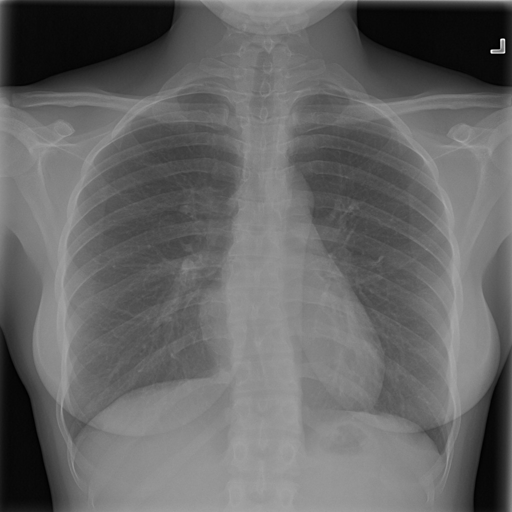

In [10]:
Image.open(train_path[0])

### Preprocessing
In this step, we defined the data preprocessing pipeline for our dataset. We used the PyTorch library's transforms module to perform a series of image transformations on the dataset.

The images are preprocessed by resizing, random rotation, flipping, center cropping, converting to tensors and normalizing using the mean and standard deviation of the dataset. These steps are performed to ensure that all the images are in the same size and format, ready to be input to the model.

In [14]:

data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.Resize(256),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'others': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [16]:
"""
Here, we have defined a custom dataset class 'TB_CXR_Dataset' which takes in a list of image paths 
and an optional transform. The class assigns a label of 0 to images with "normal" in the path and a 
label of 1 for the rest. 

After that, we used this class to create datasets for train, validation, and test data using specific 
transforms for each and created DataLoader objects for each dataset with batch size of 32.

"""
class TB_CXR_Dataset(Dataset):
    def __init__(self, images, transform=None):
        self.img_paths = images
        self.img_labels = [0 if "normal" in img else 1 for img in self.img_paths]
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # get the image path and label for the specified index
        img_path = self.img_paths[idx]
        label = self.img_labels[idx]

        # load the image from the path
        image = Image.open(img_path)
        image = image.convert("RGB")

        # apply transform
        if self.transform:
            image = self.transform(image)
        
        # return the image and label as a tuple
        return image, label

# Dataset for train, valid and test
train_data = TB_CXR_Dataset(train_path, transform = data_transforms["train"]) 
valid_data = TB_CXR_Dataset(val_path, transform = data_transforms["others"]) 
test_data = TB_CXR_Dataset(test_path, transform = data_transforms["others"]) 

# Dataloader for train, valid and test
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

## Data Visualization

In this section, we visualized the distribution of our dataset by plotting a bar graph for , as well as visualizing some images from the dataloader to ensure that they were properly loaded and transformed.

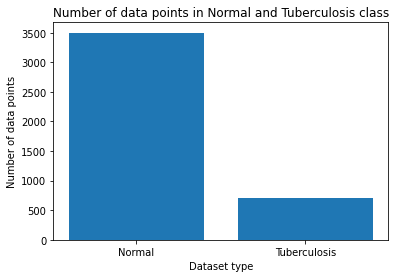

In [13]:
import matplotlib.pyplot as plt
normal_size = len(normal_df)
Tuberculosis_size = len(tuberculosis_df)
sizes = [normal_size, Tuberculosis_size]

plt.bar(['Normal', 'Tuberculosis'], sizes)

plt.xlabel('Dataset type')
plt.ylabel('Number of data points')
plt.title('Number of data points in Normal and Tuberculosis class')

plt.show()

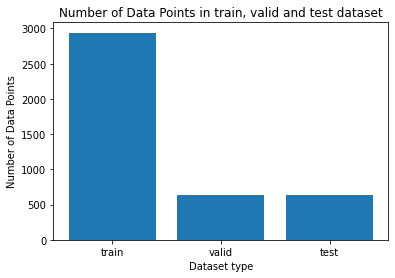

In [14]:
# Get the number of data points in each dataset
train_size = len(train_data)
valid_size = len(valid_data)
test_size = len(test_data) 

# Create a list of the sizes of each dataset
sizes = [train_size, valid_size, test_size]

# Create a bar plot with the sizes of the datasets
plt.bar(['train', 'valid', 'test'], sizes)

# Add labels and title to the plot
plt.xlabel('Dataset type')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points in train, valid and test dataset')

# Show the plot
plt.show()


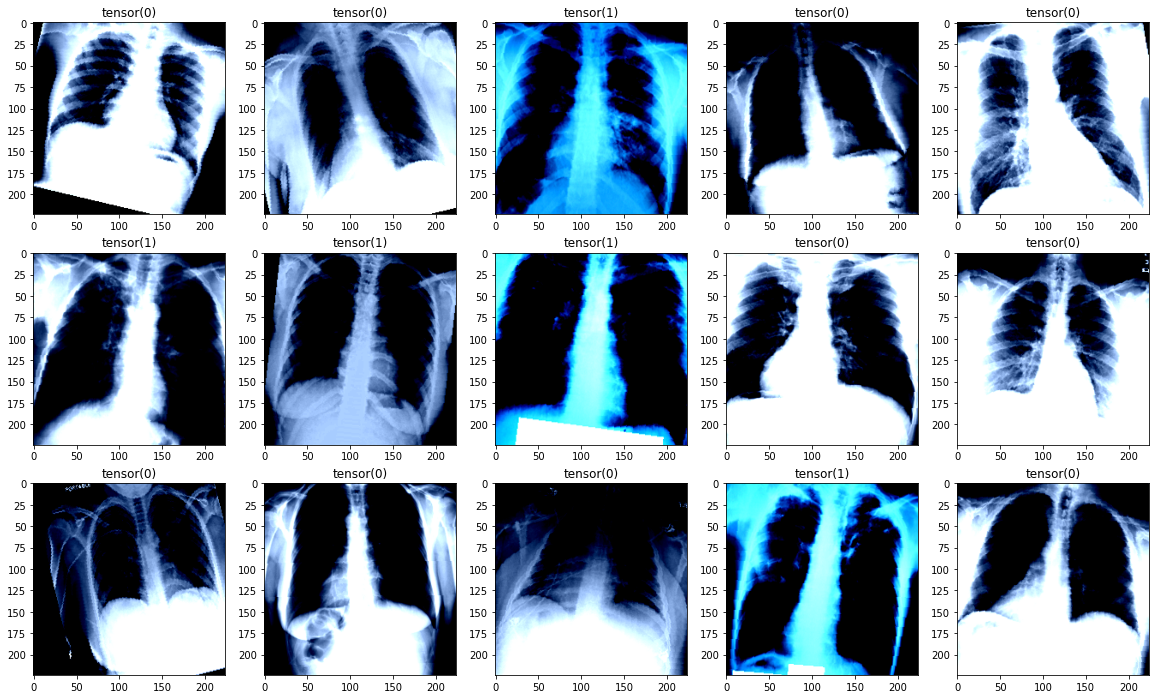

In [15]:
# Load your data using a PyTorch dataloader
data, labels = next(iter(train_dataloader))

# Create a figure with a grid of subplots
fig, axs = plt.subplots(nrows=3, ncols=5,figsize=(20, 12))

# Plot the images in the subplots
for i, ax in enumerate(axs.flat):
    # Get the image and label for the current subplot
    image, label = data[i], labels[i]
    
    # Convert the image to a numpy array and plot it
    img = image.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # img = std * img + mean
    img = np.clip(img, 0, 1)

    ax.imshow(img)
    
    # Set the title of the subplot to the label
    ax.set_title(label)

# Show the plot
plt.show()

In [4]:
from torchvision.models import densenet121,DenseNet121_Weights, DenseNet

#model architecture
class CXR_DenseNetModel(nn.Module):
  """DenseNet121 pretrained model definition."""
  def __init__(self, num_classes):
      super(CXR_DenseNetModel, self).__init__()

      self.model = torchvision.models.densenet121(pretrained=True)

      # Freeze the model's parameters
      for param in self.model.parameters():
          param.requires_grad = False

      # Replace the last linear layer of the model
      in_features = self.model.classifier.in_features
      self.model.classifier = nn.Sequential( 
          nn.Linear(in_features, in_features // 2),
          nn.Dropout(0.5),
          nn.Linear(in_features // 2, in_features // 4),
          # nn.Dropout(0.5),
          nn.Linear(in_features // 4, in_features // 8),
          nn.Dropout(0.25),
          nn.Linear(in_features // 8, num_classes),
      )

  def forward(self, x):
      return self.model(x)

model = CXR_DenseNetModel(num_classes=2)


# set device
model = model.to(device) 
model


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

CXR_DenseNetModel(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mome

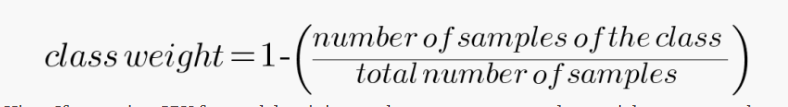

In [17]:
# calculating weights for each classes

def class_weight(x,total):
  return 1 - (x/total)

total = 2450 + 490
class_weights = torch.tensor([class_weight(2450,total),class_weight(490,total)])

In [18]:
# Define the Binary CrossEntropy with Logits loss function and Adam optimizer
loss_fn = nn.BCEWithLogitsLoss(weight = class_weights.to(device))
optimizer = optim.Adam(model.parameters(),lr=0.001)

# Decay LR by a factor of 0.1 every 3 epochs
# scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [19]:
from tqdm import tqdm
train_losses = []
valid_losses = []
train_acc = []
valid_acc=[]
# Define a function for the training loop
def train(model, loss_fn, optimizer, num_epochs):

    for epoch in tqdm(range(num_epochs)):

        # Training
        # Set the model to training mode
        model.train()

        train_size = 0
        train_loss = 0.0
        train_accuracy = 0.0

        # Loop through the training dataloader
        for batch_idx, (images, labels) in enumerate(train_dataloader):
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, F.one_hot(labels,2).float())

            # Compute accuracy
            _, preds = torch.max(outputs, 1)
            train_accuracy += torch.sum(preds == labels.data)

            # Backward pass
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            train_size += images.size(0)

        # Validation
        # Set the model to evalutaion mode
        model.eval()

        valid_size = 0
        valid_loss = 0.0
        valid_accuracy = 0.0

        # Loop through the validing dataloader
        for batch_idx, (images, labels) in enumerate(valid_dataloader):
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, F.one_hot(labels,2).float())

            # Compute accuracy
            _, preds = torch.max(outputs, 1)
            valid_accuracy += torch.sum(preds == labels.data)

            # Backward pass
            loss.backward()
            optimizer.step()

            valid_loss += loss.item() * images.size(0)
            valid_size += images.size(0)

        # Print training and validation statistics
        train_loss = train_loss / train_size
        train_losses.append(train_loss)
        train_accuracy = train_accuracy / train_size
        train_acc.append(train_accuracy)

        valid_loss = valid_loss / valid_size
        valid_losses.append(valid_loss)

        valid_accuracy = valid_accuracy / valid_size
        valid_acc.append(valid_accuracy)

        
        print(f"\nTrain Loss: {train_loss:.3f},Train Accuracy: {train_accuracy:.3f}, Valid Loss: {valid_loss:.3f}, Valid Accuracy: {valid_accuracy:.2f}")

# Train the model
train(model, loss_fn, optimizer, num_epochs=25)

  4%|▍         | 1/25 [00:56<22:28, 56.21s/it]


Train Loss: 0.109,Train Accuracy: 0.924, Valid Loss: 0.056, Valid Accuracy: 0.96


  8%|▊         | 2/25 [01:44<19:49, 51.71s/it]


Train Loss: 0.086,Train Accuracy: 0.950, Valid Loss: 0.040, Valid Accuracy: 0.98


 12%|█▏        | 3/25 [02:33<18:28, 50.40s/it]


Train Loss: 0.053,Train Accuracy: 0.964, Valid Loss: 0.024, Valid Accuracy: 0.99


 16%|█▌        | 4/25 [03:21<17:15, 49.29s/it]


Train Loss: 0.053,Train Accuracy: 0.960, Valid Loss: 0.020, Valid Accuracy: 0.98


 20%|██        | 5/25 [04:08<16:14, 48.70s/it]


Train Loss: 0.052,Train Accuracy: 0.965, Valid Loss: 0.017, Valid Accuracy: 0.99


 24%|██▍       | 6/25 [04:56<15:18, 48.34s/it]


Train Loss: 0.049,Train Accuracy: 0.966, Valid Loss: 0.017, Valid Accuracy: 0.99


 28%|██▊       | 7/25 [05:45<14:32, 48.45s/it]


Train Loss: 0.038,Train Accuracy: 0.972, Valid Loss: 0.024, Valid Accuracy: 0.97


 32%|███▏      | 8/25 [06:32<13:39, 48.19s/it]


Train Loss: 0.038,Train Accuracy: 0.973, Valid Loss: 0.009, Valid Accuracy: 1.00


 36%|███▌      | 9/25 [07:20<12:47, 48.00s/it]


Train Loss: 0.054,Train Accuracy: 0.967, Valid Loss: 0.026, Valid Accuracy: 0.98


 40%|████      | 10/25 [08:08<11:58, 47.92s/it]


Train Loss: 0.036,Train Accuracy: 0.974, Valid Loss: 0.021, Valid Accuracy: 0.99


 44%|████▍     | 11/25 [08:56<11:10, 47.92s/it]


Train Loss: 0.048,Train Accuracy: 0.967, Valid Loss: 0.023, Valid Accuracy: 0.99


 48%|████▊     | 12/25 [09:43<10:22, 47.87s/it]


Train Loss: 0.045,Train Accuracy: 0.969, Valid Loss: 0.020, Valid Accuracy: 0.98


 52%|█████▏    | 13/25 [10:32<09:37, 48.10s/it]


Train Loss: 0.041,Train Accuracy: 0.974, Valid Loss: 0.009, Valid Accuracy: 1.00


 56%|█████▌    | 14/25 [11:20<08:47, 47.98s/it]


Train Loss: 0.045,Train Accuracy: 0.972, Valid Loss: 0.008, Valid Accuracy: 1.00


 60%|██████    | 15/25 [12:07<07:58, 47.85s/it]


Train Loss: 0.032,Train Accuracy: 0.979, Valid Loss: 0.009, Valid Accuracy: 0.99


 64%|██████▍   | 16/25 [12:55<07:09, 47.76s/it]


Train Loss: 0.038,Train Accuracy: 0.971, Valid Loss: 0.018, Valid Accuracy: 0.99


 68%|██████▊   | 17/25 [13:42<06:21, 47.73s/it]


Train Loss: 0.035,Train Accuracy: 0.976, Valid Loss: 0.007, Valid Accuracy: 1.00


 72%|███████▏  | 18/25 [14:31<05:36, 48.05s/it]


Train Loss: 0.047,Train Accuracy: 0.968, Valid Loss: 0.014, Valid Accuracy: 0.99


 76%|███████▌  | 19/25 [15:19<04:47, 47.91s/it]


Train Loss: 0.047,Train Accuracy: 0.968, Valid Loss: 0.014, Valid Accuracy: 0.99


 80%|████████  | 20/25 [16:06<03:59, 47.82s/it]


Train Loss: 0.032,Train Accuracy: 0.975, Valid Loss: 0.014, Valid Accuracy: 0.99


 84%|████████▍ | 21/25 [16:54<03:11, 47.79s/it]


Train Loss: 0.040,Train Accuracy: 0.973, Valid Loss: 0.013, Valid Accuracy: 0.99


 88%|████████▊ | 22/25 [17:42<02:23, 47.75s/it]


Train Loss: 0.039,Train Accuracy: 0.973, Valid Loss: 0.011, Valid Accuracy: 0.99


 92%|█████████▏| 23/25 [18:29<01:35, 47.71s/it]


Train Loss: 0.043,Train Accuracy: 0.971, Valid Loss: 0.010, Valid Accuracy: 1.00


 96%|█████████▌| 24/25 [19:18<00:47, 48.00s/it]


Train Loss: 0.034,Train Accuracy: 0.978, Valid Loss: 0.011, Valid Accuracy: 0.99


100%|██████████| 25/25 [20:06<00:00, 48.25s/it]


Train Loss: 0.053,Train Accuracy: 0.968, Valid Loss: 0.005, Valid Accuracy: 1.00


## Evaluation

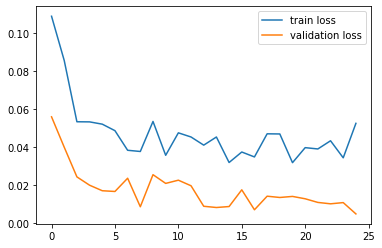

In [36]:
# plot train and test losses
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='validation loss')
plt.legend()
plt.show()

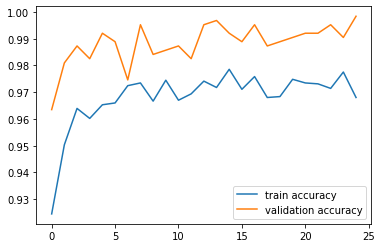

In [37]:
# plot train and test acc
train_acc_np= np.array([x.cpu().numpy() for x in train_acc])
valid_acc_np= np.array([x.cpu().numpy() for x in valid_acc])

plt.plot(train_acc_np, label='train accuracy')
plt.plot(valid_acc_np, label='validation accuracy')
plt.legend()
plt.show()

### Test set evaluation

In [22]:
# Evaluation on test set
y_true = []
y_hat = []

test_size = 0
test_loss = 0.0
test_accuracy = 0.0
# Loop through the testing dataloader
for batch_idx, (images, labels) in enumerate(test_dataloader):
    images, labels = images.to(device), labels.to(device)

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(images)
    loss = loss_fn(outputs, F.one_hot(labels,2).float())

    # Compute accuracy
    _, preds = torch.max(outputs, 1)
    test_accuracy += torch.sum(preds == labels.data)

    y_true.extend(labels.detach().cpu().numpy().tolist())
    y_hat.extend(preds.detach().cpu().numpy().tolist())

    # Backward pass
    loss.backward()
    optimizer.step()

    test_loss += loss.item() * images.size(0)
    test_size += images.size(0)

In [23]:
import torchmetrics
from torchmetrics.classification import BinaryAccuracy, BinaryAUROC, BinaryF1Score
from mlxtend.plotting import plot_confusion_matrix

metrics_acc = BinaryAccuracy()
metric_auroc = BinaryAUROC(thresholds=None)
metric_f1 = BinaryF1Score()

target = torch.tensor(y_true)
preds = torch.tensor(y_hat)

# Accuracy
acc = metrics_acc(preds, target)

# AUROC
auroc = metric_auroc(preds, target)

# F1 Score
f1 = metric_f1(preds, target)

print("Test Accuracy: ", acc)
print("Test AUROC: ", auroc)
print("Test F1: ", f1)

Test Accuracy:  tensor(0.9841)
Test AUROC:  tensor(0.9752)
Test F1:  tensor(0.9528)


In [24]:
# Classification Report

from sklearn.metrics import classification_report
target_names = ['normal', 'tuberculosis']
print(classification_report(y_true, y_hat, target_names=target_names))

              precision    recall  f1-score   support

      normal       0.99      0.99      0.99       525
tuberculosis       0.94      0.96      0.95       105

    accuracy                           0.98       630
   macro avg       0.97      0.98      0.97       630
weighted avg       0.98      0.98      0.98       630



In [25]:
from sklearn.metrics import confusion_matrix

# Order of the input parameters is important: 
# first param is the actual output values
# second param is what our model predicted
conf_matrix = confusion_matrix(y_true, y_hat)

conf_matrix

array([[519,   6],
       [  4, 101]])

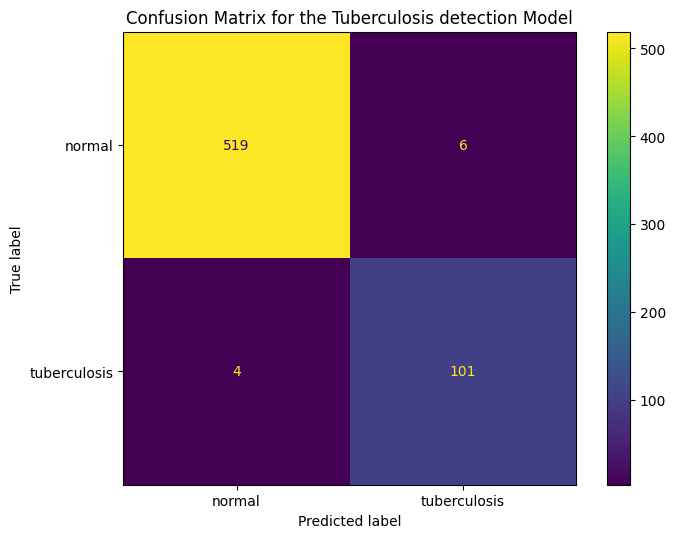

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Change figure size and increase dpi for better resolution
# and get reference to axes object
fig, ax = plt.subplots(figsize=(8,6), dpi=100)

# initialize using the raw 2D confusion matrix 
# and output labels (in our case, it's 0 and 1)
display = ConfusionMatrixDisplay(conf_matrix, display_labels=['normal', 'tuberculosis'])

# set the plot title using the axes object
ax.set(title='Confusion Matrix for the Tuberculosis detection Model')

# show the plot. 
# Pass the parameter ax to show customizations (ex. title) 
display.plot(ax=ax);

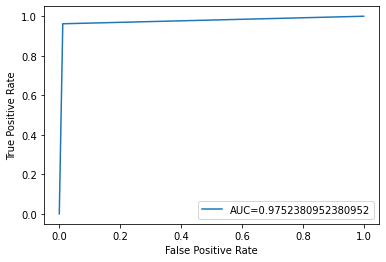

In [27]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_true,  y_hat)
auc = metrics.roc_auc_score(y_true, y_hat)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

#Saving and loading model

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
from pathlib import Path

# create model directory path
MODEL_PATH = Path('/content/drive/MyDrive/TubersavedModel')
MODEL_PATH.mkdir(parents = True,
                 exist_ok = True)

# create model save
MODEL_NAME = '01_tuberculosis_model.pth'
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME



# save the entire model
print(f'saving the entire model to :{MODEL_SAVE_PATH}')
torch.save(model, MODEL_SAVE_PATH)

saving the entire model to :/content/drive/MyDrive/TubersavedModel/01_tuberculosis_model.pth


In [7]:
# loading model
PATH = "/content/drive/MyDrive/TubersavedModel/01_tuberculosis_model.pth"
model = torch.load(PATH,map_location=torch.device('cpu'))

In [31]:
# saving the model in onnx format
import torch.onnx 

 # set the model to inference mode
model.eval()

# Input to the model
x = torch.randn(1, 3, 224, 224, requires_grad=True)

input_names = [ "actual_input" ]
output_names = [ "output" ]

torch.onnx.export(model,
                 x,
                 "/content/drive/MyDrive/TubersavedModel/tuberModel.onnx",
                 verbose=False,
                 input_names=input_names,
                 output_names=output_names,
                 export_params=True,
                 )

In [32]:
from PIL import Image
import torchvision.transforms as transforms

img = Image.open("datasets/tuberculosis/Tuberculosis-1.png")

transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
img = transform(img)
img = img.unsqueeze_(0)

# Grad CAM visualizaition (Explainable AI)

In [33]:
# !pip install torchcam

In [34]:
# !pip install pytorch-gradcam

In [35]:
# !pip install omnixai[vision]